# Âü∫‰∫é‰ΩçÁΩÆÊñπÂ∑ÆÁöÑÊú∫Âô®‰∫∫ËøêÂä®Â≠¶ÂèÇÊï∞Ê†áÂÆö

ÁõÆÊ†áÂáΩÊï∞:ÊúÄÂ∞èÂåñËßÇÊµãÁÇπ‰ΩçÁΩÆÊñπÂ∑Æ
ÁõÆÊ†áÁ≤æÂ∫¶:‰ΩçÁΩÆÊ†áÂáÜÂ∑Æ1mm‰ª•ÂÜÖ

In [1]:
import torch
import numpy as np


print("=== Position Variance-Based Robot Kinematics Parameter Calibration Demo ===")
print("Objective Function: Minimize variance of observed positions")
print("Target precision: Position standard deviation < 1 mm")

=== Position Variance-Based Robot Kinematics Parameter Calibration Demo ===
Objective Function: Minimize variance of observed positions
Target precision: Position standard deviation < 1 mm


## 1. ÂàõÂª∫Êú∫Âô®‰∫∫Ê®°Âûã

In [2]:
from robot_model.robots import create_robot
import numpy as np

# ‰ΩøÁî®Áé∞ÊàêÁöÑÊú∫Âô®‰∫∫ÂàõÂª∫ÂáΩÊï∞
robot_name = "ABB6700"  # ËÆæÁΩÆÊú∫Âô®‰∫∫ÂêçÁß∞
robot = create_robot(robot_name=robot_name)

print(f"Created robot: {robot.name}")
print(f"Robot DOF: {robot.n}")

# ÊâìÂç∞Êú∫Âô®‰∫∫ÂèÇÊï∞
print("\nRobot DH Parameters:")
for i, link in enumerate(robot.links):
    print(f"Link {i+1}: a={link.a.item():.1f}mm, d={link.d.item():.1f}mm, "
          f"alpha={np.degrees(link.alpha.item()):.1f}¬∞, beta={np.degrees(link.beta.item()):.1f}¬∞, "
          f"theta_offset={np.degrees(link.offset.item()):.1f}¬∞")

# ÊâìÂç∞baseÂèòÊç¢
print("\nBase Transform (World to Robot Base):")
if hasattr(robot, 'base') and robot.base is not None:
    base_pos = robot.base[0:3, 3]
    print(f"  Translation: x={base_pos[0]:.1f}mm, y={base_pos[1]:.1f}mm, z={base_pos[2]:.1f}mm")
    print(f"  Base transform shape: {robot.base.shape}")
else:
    print("  No base transform defined")

# ÊâìÂç∞ÊâãÁúºÂèÇÊï∞(Áé∞Âú®ÊòØÂèØÊ†°ÂáÜÁöÑ)
print("\nHand-Eye Parameters (Calibratable):")
print(f"  Translation: tx={robot.tx.item():.1f}mm, ty={robot.ty.item():.1f}mm, tz={robot.tz.item():.1f}mm")
print(f"  Rotation: rx={robot.rx.item():.3f}rad, ry={robot.ry.item():.3f}rad, rz={robot.rz.item():.3f}rad")
print(f"  Tool transform shape: {robot.tool.shape}")

# ÊµãËØïÂâçÂêëËøêÂä®Â≠¶
q_test = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]  # 6‰∏™ÂÖ≥ËäÇËßíÂ∫¶
print(f"\nTest joint angles: {q_test}")
T_test = robot.fkine(q_test)
print(f"Forward kinematics test passed")
print(f"End effector position: {T_test[0:3, 3].detach().numpy()}")
print(f"End effector position (mm): {T_test[0:3, 3].detach().numpy()}")

Created robot: ABB6700_Calibration_Robot
Robot DOF: 6

Robot DH Parameters:
Link 1: a=320.0mm, d=780.0mm, alpha=-90.0¬∞, beta=0.0¬∞, theta_offset=0.0¬∞
Link 2: a=1125.0mm, d=0.0mm, alpha=0.0¬∞, beta=0.0¬∞, theta_offset=-90.0¬∞
Link 3: a=200.0mm, d=-0.0mm, alpha=-90.0¬∞, beta=0.0¬∞, theta_offset=0.0¬∞
Link 4: a=0.0mm, d=1392.5mm, alpha=-90.0¬∞, beta=0.0¬∞, theta_offset=-180.0¬∞
Link 5: a=-0.0mm, d=0.0mm, alpha=-90.0¬∞, beta=0.0¬∞, theta_offset=-180.0¬∞
Link 6: a=-0.0mm, d=200.0mm, alpha=-0.0¬∞, beta=0.0¬∞, theta_offset=180.0¬∞

Base Transform (World to Robot Base):
  Translation: x=0.0mm, y=0.0mm, z=0.0mm
  Base transform shape: torch.Size([4, 4])

Hand-Eye Parameters (Calibratable):
  Translation: tx=0.0mm, ty=0.0mm, tz=0.0mm
  Rotation: rx=0.000rad, ry=0.000rad, rz=0.000rad
  Tool transform shape: torch.Size([4, 4])

Test joint angles: [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]
Forward kinematics test passed
End effector position: [2004.02537535  205.05991332 1261.82201599]
End effector position 

## 2.ÊâãÁúºÈ¢ÑÊ†áÂÆö

In [3]:
from eye_hand_pre_cali.pre_calibrator import PreCalibrator
import os
import torch
import json

print("=== ÊâãÁúºÈ¢ÑÊ†áÂÆö ===")

# ÂàõÂª∫È¢ÑÊ†áÂÆöÂô®ÂÆû‰æã
pre_calibrator = PreCalibrator()

# ÈÖçÁΩÆÊï∞ÊçÆË∑ØÂæÑ - ‰ΩøÁî®Êñ∞Ê†ºÂºèÁöÑobservations.jsonÊñá‰ª∂
data_file = os.path.join(os.getcwd(), "data", "hand_eye_data", "ABB_5", "observations.json")

print("Ê≠£Âú®Âä†ËΩΩÈ¢ÑÂ§ÑÁêÜÁöÑËßÇÊµãÊï∞ÊçÆ...")
print(f"Êï∞ÊçÆÊñá‰ª∂Ë∑ØÂæÑ: {data_file}")

# Ê£ÄÊü•Êï∞ÊçÆÊñá‰ª∂ÊòØÂê¶Â≠òÂú®
if not os.path.exists(data_file):
    print(f"‚ùå ËßÇÊµãÊï∞ÊçÆÊñá‰ª∂ {data_file} ‰∏çÂ≠òÂú®")
    print("ËØ∑ÂÖàËøêË°åÊï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÁ®ãÂ∫èÁîüÊàêobservations.jsonÊñá‰ª∂")
else:
    try:
        # Áõ¥Êé•‰ªéJSONÊñá‰ª∂Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ
        print("Ê≠£Âú®‰ªéJSONÊñá‰ª∂Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ...")
        success = pre_calibrator.load_observations_from_json(data_file)
        
        if success:
            # Ê£ÄÊü•Êï∞ÊçÆÊòØÂê¶Ë∂≥Â§üËøõË°åÈ¢ÑÊ†áÂÆö
            num_observations = len(pre_calibrator.observations)
            print(f"‚úì ÊàêÂäüÂä†ËΩΩ {num_observations} ‰∏™ËßÇÊµãÊï∞ÊçÆ")
            
            if num_observations >= 12:
                # ÊâßË°åÈ¢ÑÊ†áÂÆö
                print("ÂºÄÂßãÊâßË°åÊâãÁúºÈ¢ÑÊ†áÂÆö...")
                pre_result = pre_calibrator.pre_calibrator()

                if pre_result:
                    print("\n=== ÊâãÁúºÈ¢ÑÊ†áÂÆöÁªìÊûú ===")
                    print(f"Âπ≥Áßª: x={pre_result['translation'][0]:.3f}, y={pre_result['translation'][1]:.3f}, z={pre_result['translation'][2]:.3f} mm")
                    print(f"ÊóãËΩ¨: r={pre_result['euler_angles'][0]:.3f}, p={pre_result['euler_angles'][1]:.3f}, y={pre_result['euler_angles'][2]:.3f} rad")
                    print(f"ÊóãËΩ¨Áü©Èòµ:\n{pre_result['rotation_matrix']}")
                    print(f"ÂèòÊç¢Áü©Èòµ:\n{pre_result['transform_matrix']}")

                    # Â∞ÜÈ¢ÑÊ†áÂÆöÁªìÊûúÂ∫îÁî®Âà∞Êú∫Âô®‰∫∫Ê®°Âûã
                    print("\nÂ∫îÁî®È¢ÑÊ†áÂÆöÁªìÊûúÂà∞Êú∫Âô®‰∫∫Ê®°Âûã...")
                    # ‰ΩøÁî®.dataÂ±ûÊÄßÊù•Êõ¥Êñ∞torch.nn.ParameterÁöÑÂÄº
                    robot.tx.data = torch.tensor(pre_result['translation'][0], dtype=torch.float64)
                    robot.ty.data = torch.tensor(pre_result['translation'][1], dtype=torch.float64)
                    robot.tz.data = torch.tensor(pre_result['translation'][2], dtype=torch.float64)
                    robot.rx.data = torch.tensor(pre_result['euler_angles'][0], dtype=torch.float64)
                    robot.ry.data = torch.tensor(pre_result['euler_angles'][1], dtype=torch.float64)
                    robot.rz.data = torch.tensor(pre_result['euler_angles'][2], dtype=torch.float64)

                    print("‚úì È¢ÑÊ†áÂÆöÁªìÊûúÂ∑≤Â∫îÁî®Âà∞Êú∫Âô®‰∫∫Ê®°Âûã")
                    print(f"Êõ¥Êñ∞ÂêéÁöÑÊâãÁúºÂèÇÊï∞:")
                    print(f"  Translation: tx={robot.tx.item():.3f}mm, ty={robot.ty.item():.3f}mm, tz={robot.tz.item():.3f}mm")
                    print(f"  Rotation: rx={robot.rx.item():.3f}rad, ry={robot.ry.item():.3f}rad, rz={robot.rz.item():.3f}rad")
                else:
                    print("‚ùå ÊâãÁúºÈ¢ÑÊ†áÂÆöÂ§±Ë¥•")
            else:
                print(f"‚ùå ËßÇÊµãÊï∞ÊçÆ‰∏çË∂≥ÔºåÈúÄË¶ÅËá≥Â∞ë12ÁªÑÔºåÂΩìÂâçÂè™Êúâ{num_observations}ÁªÑ")
        else:
            print("‚ùå ËßÇÊµãÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•")

    except Exception as e:
        print(f"‚ùå È¢ÑÊ†áÂÆöËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {str(e)}")
        import traceback
        traceback.print_exc()

=== ÊâãÁúºÈ¢ÑÊ†áÂÆö ===
Ê≠£Âú®Âä†ËΩΩÈ¢ÑÂ§ÑÁêÜÁöÑËßÇÊµãÊï∞ÊçÆ...
Êï∞ÊçÆÊñá‰ª∂Ë∑ØÂæÑ: d:\Ê°åÈù¢\ÂÆû‰π†\diff_cali\data\hand_eye_data\ABB_5\observations.json
Ê≠£Âú®‰ªéJSONÊñá‰ª∂Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ...
‚úì ÊàêÂäüËÆæÁΩÆ 12 ‰∏™ËßÇÊµãÊï∞ÊçÆ
‚úì ÊàêÂäü‰ªé d:\Ê°åÈù¢\ÂÆû‰π†\diff_cali\data\hand_eye_data\ABB_5\observations.json Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ
‚úì ÊàêÂäüÂä†ËΩΩ 12 ‰∏™ËßÇÊµãÊï∞ÊçÆ
ÂºÄÂßãÊâßË°åÊâãÁúºÈ¢ÑÊ†áÂÆö...
=== ÊâãÁúºÈ¢ÑÊ†áÂÆö (È´òÁ≤æÂ∫¶ÁâàÊú¨) ===
ËßÇÊµã 1: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [-46.200940, -28.147055, 381.991300]
ËßÇÊµã 2: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [-36.571680, 28.038240, 327.761410]
ËßÇÊµã 3: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [36.157537, 27.238920, 314.621639]
ËßÇÊµã 4: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [41.454871, -26.266543, 346.582040]
ËßÇÊµã 5: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [6.556315, -0.401477, 321.156727]
ËßÇÊµã 6: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [12.802378, 8.888559, 337.015019]
ËßÇÊµã 7: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [23.661549, -7.822237, 342.115369]
ËßÇÊµã 8: ‰ΩøÁî®È¢ÑËÆ°ÁÆóÁêÉÂøÉ = [3.376245, 1.855050, 346.111587]
ËßÇÊµ

## 3. ÂàõÂª∫Ê†°ÂáÜÂô®

In [4]:
from main_cali.calibrator import RobotCalibrator

# ÂàõÂª∫È´òÁ≤æÂ∫¶Ê†°ÂáÜÂô®,‰ΩøÁî®Êñ∞ÁöÑÊéíÈô§ËßÑÂàô
calibrator = RobotCalibrator(
    robot, 
    calibration_params=['a', 'alpha', 'd', 'beta', 'offset', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz'], 
    excluded_params={
        0: ['d','beta'],           # ÊéíÈô§Á¨¨‰∏ÄÂÖ≥ËäÇ(Á¥¢Âºï0)ÁöÑdÂíåbetaÂèÇÊï∞
        1: ['d'],                   # ÊéíÈô§Á¨¨‰∫åÂÖ≥ËäÇ(Á¥¢Âºï1)ÁöÑdÂèÇÊï∞  
        2: ['d','beta'],                   # ÊéíÈô§Á¨¨‰∏âÂÖ≥ËäÇ(Á¥¢Âºï2)ÁöÑdÂèÇÊï∞
        3: ['beta'],           # ÊéíÈô§Á¨¨ÂõõÂÖ≥ËäÇ(Á¥¢Âºï3)ÁöÑdÂíåbetaÂèÇÊï∞
        4: ['beta'],               # ÊéíÈô§Á¨¨‰∫îÂÖ≥ËäÇ(Á¥¢Âºï4)ÁöÑbetaÂèÇÊï∞
        5: ['a', 'alpha', 'd', 'beta', 'offset']                # ÊéíÈô§Á¨¨ÂÖ≠ÂÖ≥ËäÇ(Á¥¢Âºï5)ÁöÑÊâÄÊúâÂèÇÊï∞
    },
    target_precision=1e-4,
    enable_outlier_detection=False
)
print(f"Created high-precision calibrator")
print(f"Calibration parameters: {calibrator.calibration_params}")
print(f"Target precision (variance): {calibrator.target_precision:.2e}")
print("Excluded parameters:")
print("  Joint 0 (Link 1): d, beta")
print("  Joint 1 (Link 2): d") 
print("  Joint 2 (Link 3): d")
print("  Joint 3 (Link 4): d, beta")
print("  Joint 4 (Link 5): beta")
print("  Joint 5 (Link 6): beta")
print("Note: Hand-eye parameters (tx, ty, tz, rx, ry, rz) included for calibration")

Created high-precision calibrator
Calibration parameters: ['a', 'alpha', 'd', 'beta', 'offset', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz']
Target precision (variance): 1.00e-04
Excluded parameters:
  Joint 0 (Link 1): d, beta
  Joint 1 (Link 2): d
  Joint 2 (Link 3): d
  Joint 3 (Link 4): d, beta
  Joint 4 (Link 5): beta
  Joint 5 (Link 6): beta
Note: Hand-eye parameters (tx, ty, tz, rx, ry, rz) included for calibration


## 4. ËØªÂèñËßÇÊµãÊï∞ÊçÆ

In [5]:
from main_cali.calibrator import RobotCalibrator
import os

print("=== ËØªÂèñËßÇÊµãÊï∞ÊçÆ ===")

# ÈÖçÁΩÆmain_dataÊï∞ÊçÆË∑ØÂæÑ - ‰ΩøÁî®Êñ∞Ê†ºÂºèÁöÑobservations.jsonÊñá‰ª∂
data_file = os.path.join(os.getcwd(), "data", "main_data", "ABB_2", "observations.json")

print("Ê≠£Âú®Âä†ËΩΩÈ¢ÑÂ§ÑÁêÜÁöÑËßÇÊµãÊï∞ÊçÆ...")
print(f"Êï∞ÊçÆÊñá‰ª∂Ë∑ØÂæÑ: {data_file}")

# Ê£ÄÊü•Êï∞ÊçÆÊñá‰ª∂ÊòØÂê¶Â≠òÂú®
if not os.path.exists(data_file):
    print(f"‚ùå ËßÇÊµãÊï∞ÊçÆÊñá‰ª∂ {data_file} ‰∏çÂ≠òÂú®")
    print("ËØ∑ÂÖàËøêË°åÊï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÁ®ãÂ∫èÁîüÊàêobservations.jsonÊñá‰ª∂")
    observations = None
else:
    try:
        # Áõ¥Êé•‰ªéJSONÊñá‰ª∂Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ
        print("Ê≠£Âú®‰ªéJSONÊñá‰ª∂Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ...")
        success = calibrator.load_observations_from_json(data_file)
        
        if success:
            observations = calibrator.observations
            print(f"‚úì ËßÇÊµãÊï∞ÊçÆÂ∑≤ÊàêÂäüËÆæÁΩÆÂà∞Ê†°ÂáÜÂô®")
            
            # ÊòæÁ§∫Êï∞ÊçÆÊ†ºÂºè‰ø°ÊÅØ
            print(f"\n=== Êï∞ÊçÆÊ†ºÂºè‰ø°ÊÅØ ===")
            print(f"ËßÇÊµãÊï∞ÊçÆÊï∞Èáè: {len(observations)}")
            sample_obs = observations[0]
            print(f"Ê†∑Êú¨ËßÇÊµãÊï∞ÊçÆÁªìÊûÑ:")
            for key in sample_obs.keys():
                if key == 'joint_state':
                    print(f"  {key}: {type(sample_obs[key])} (ÈïøÂ∫¶: {len(sample_obs[key])})")
                elif key == 'point_cloud_center':
                    print(f"  {key}: {type(sample_obs[key])} (Áª¥Â∫¶: {sample_obs[key].shape if hasattr(sample_obs[key], 'shape') else len(sample_obs[key])})")
                else:
                    print(f"  {key}: {type(sample_obs[key])}")
        else:
            print("‚ùå ËßÇÊµãÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•")
            observations = None
                
    except Exception as e:
        print(f"‚ùå Êï∞ÊçÆÂä†ËΩΩËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {str(e)}")
        import traceback
        traceback.print_exc()
        observations = None

# Ê£ÄÊü•ÊúÄÁªàÁªìÊûú
if observations is None or len(observations) == 0:
    print("‚ùå Êó†Ê≥ïËÆæÁΩÆËßÇÊµãÊï∞ÊçÆÂà∞Ê†°ÂáÜÂô®ÔºåËØ∑Ê£ÄÊü•Êï∞ÊçÆÊñá‰ª∂")

=== ËØªÂèñËßÇÊµãÊï∞ÊçÆ ===
Ê≠£Âú®Âä†ËΩΩÈ¢ÑÂ§ÑÁêÜÁöÑËßÇÊµãÊï∞ÊçÆ...
Êï∞ÊçÆÊñá‰ª∂Ë∑ØÂæÑ: d:\Ê°åÈù¢\ÂÆû‰π†\diff_cali\data\main_data\ABB_2\observations.json
Ê≠£Âú®‰ªéJSONÊñá‰ª∂Âä†ËΩΩËßÇÊµãÊï∞ÊçÆ...
Loaded 30 observations with precomputed centers
‚úì ÊàêÂäü‰ªé d:\Ê°åÈù¢\ÂÆû‰π†\diff_cali\data\main_data\ABB_2\observations.json Âä†ËΩΩ 30 ‰∏™ËßÇÊµãÊï∞ÊçÆ
‚úì ËßÇÊµãÊï∞ÊçÆÂ∑≤ÊàêÂäüËÆæÁΩÆÂà∞Ê†°ÂáÜÂô®

=== Êï∞ÊçÆÊ†ºÂºè‰ø°ÊÅØ ===
ËßÇÊµãÊï∞ÊçÆÊï∞Èáè: 30
Ê†∑Êú¨ËßÇÊµãÊï∞ÊçÆÁªìÊûÑ:
  id: <class 'int'>
  joint_state: <class 'list'> (ÈïøÂ∫¶: 6)
  point_cloud_center: <class 'list'> (Áª¥Â∫¶: 3)


Calculating end effector positions from observations...
Calculated 30 end effector positions


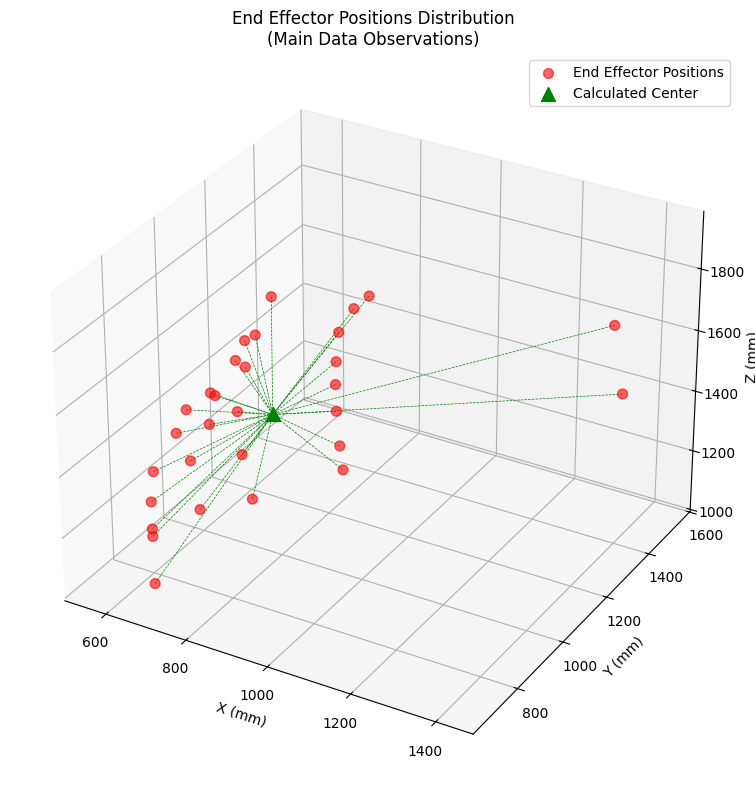


=== End Effector Position Statistics ===
Number of positions: 30
Calculated center: [788.5, 989.1, 1463.3] mm
Mean distance from center: 336.73 mm
Distance std dev: 159.56 mm
Position range:
  X: 670.9 to 1311.4 mm
  Y: 611.4 to 1602.7 mm
  Z: 1093.7 to 1882.5 mm
Estimated workspace volume: 0.50 m¬≥


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# Ê£ÄÊü•ÊòØÂê¶ÊúâËßÇÊµãÊï∞ÊçÆ
if 'observations' not in locals() or observations is None or len(observations) == 0:
    print("‚ùå Ê≤°ÊúâÂèØÁî®ÁöÑËßÇÊµãÊï∞ÊçÆËøõË°åÂèØËßÜÂåñ")
else:
    # ËÆ°ÁÆóÊâÄÊúâËßÇÊµãÁÇπÁöÑÊú´Á´Ø‰ΩçÁΩÆ
    print("Calculating end effector positions from observations...")
    end_positions = []
    joint_positions = []

    for obs in observations:
        q = obs['joint_state']
        joint_positions.append(q)
        
        # ‰ΩøÁî®Êú∫Âô®‰∫∫ËÆ°ÁÆóÊú´Á´Ø‰ΩçÁΩÆ
        T = robot.fkine(q)
        pos = T[0:3, 3].detach().numpy()
        end_positions.append(pos)

    end_positions = np.array(end_positions)
    print(f"Calculated {len(end_positions)} end effector positions")

    # ÂàõÂª∫3DÂèØËßÜÂåñ
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # ÁªòÂà∂Êú´Á´Ø‰ΩçÁΩÆÁÇπ
    ax.scatter(end_positions[:, 0], end_positions[:, 1], end_positions[:, 2], 
               c='red', alpha=0.6, s=50, label='End Effector Positions')

    # ËÆ°ÁÆóÂπ∂ÊòæÁ§∫‰ΩçÁΩÆÁªüËÆ°
    center_calc = np.mean(end_positions, axis=0)
    ax.scatter(center_calc[0], center_calc[1], center_calc[2], 
               c='green', s=100, marker='^', label='Calculated Center')
    
    # ‰ªéÊØè‰∏™ÁÇπÂà∞‰∏≠ÂøÉÁöÑËøûÁ∫ø
    for i, pos in enumerate(end_positions):
        ax.plot([pos[0], center_calc[0]], [pos[1], center_calc[1]], [pos[2], center_calc[2]], 
                'g--', alpha=1, linewidth=0.5)

    # ËÆæÁΩÆÂõæÂΩ¢Â±ûÊÄß
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('End Effector Positions Distribution\n(Main Data Observations)')
    ax.legend()

    # Ê∑ªÂä†ÁΩëÊ†º
    ax.grid(True, alpha=0.3)

    # ËÆæÁΩÆÁõ∏Á≠âÁöÑÂùêÊ†áËΩ¥ÊØî‰æã
    max_range = np.array([end_positions[:,0].max()-end_positions[:,0].min(),
                          end_positions[:,1].max()-end_positions[:,1].min(),
                          end_positions[:,2].max()-end_positions[:,2].min()]).max() / 2.0
    mid_x = (end_positions[:,0].max()+end_positions[:,0].min()) * 0.5
    mid_y = (end_positions[:,1].max()+end_positions[:,1].min()) * 0.5
    mid_z = (end_positions[:,2].max()+end_positions[:,2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.tight_layout()
    plt.show()

    # ÊâìÂç∞ÁªüËÆ°‰ø°ÊÅØ
    print(f"\n=== End Effector Position Statistics ===")
    print(f"Number of positions: {len(end_positions)}")
    print(f"Calculated center: [{center_calc[0]:.1f}, {center_calc[1]:.1f}, {center_calc[2]:.1f}] mm")
    
    # ËÆ°ÁÆó‰ΩçÁΩÆÂàÜÂ∏ÉÁªüËÆ°
    distances_from_center = np.linalg.norm(end_positions - center_calc, axis=1)
    radius_mean = np.mean(distances_from_center)
    radius_std = np.std(distances_from_center)
    
    print(f"Mean distance from center: {radius_mean:.2f} mm")
    print(f"Distance std dev: {radius_std:.2f} mm")
    print(f"Position range:")
    print(f"  X: {end_positions[:,0].min():.1f} to {end_positions[:,0].max():.1f} mm")
    print(f"  Y: {end_positions[:,1].min():.1f} to {end_positions[:,1].max():.1f} mm")
    print(f"  Z: {end_positions[:,2].min():.1f} to {end_positions[:,2].max():.1f} mm")
    
    # ËÆ°ÁÆóÂ∑•‰ΩúÁ©∫Èó¥‰ΩìÁßØ‰º∞ÁÆó
    workspace_volume = (end_positions[:,0].max() - end_positions[:,0].min()) * \
                      (end_positions[:,1].max() - end_positions[:,1].min()) * \
                      (end_positions[:,2].max() - end_positions[:,2].min())
    print(f"Estimated workspace volume: {workspace_volume/1e9:.2f} m¬≥")

## 5. ÊâßË°åÊ†°ÂáÜ

In [7]:
# Ê£ÄÊü•ÊòØÂê¶ÊúâËßÇÊµãÊï∞ÊçÆ
if 'observations' not in locals() or observations is None or len(observations) == 0:
    print("‚ùå Ê≤°ÊúâÂèØÁî®ÁöÑËßÇÊµãÊï∞ÊçÆËøõË°åÊ†°ÂáÜ")
    print("ËØ∑ÂÖàÊàêÂäüËøêË°åÁ¨¨9‰∏™cellÂä†ËΩΩËßÇÊµãÊï∞ÊçÆ")
else:
    # ÊâßË°åÂÖ®ÊâπÈáèÊ†°ÂáÜ
    print(f"ÂáÜÂ§á‰ΩøÁî® {len(observations)} ‰∏™ËßÇÊµãÊï∞ÊçÆËøõË°åÂÖ®ÊâπÈáèÊ†°ÂáÜ")

    # ÊâßË°åÂÖ®ÊâπÈáèÊ†°ÂáÜ
    print("\nStarting full-batch variance-based calibration...")
    results = calibrator.calibrate(
        learning_rate=0.1,      # ÂÖ®ÊâπÈáèËÆ≠ÁªÉ‰ΩøÁî®Ê†áÂáÜÂ≠¶‰π†Áéá
        max_iterations=10000,     # Ê†áÂáÜËø≠‰ª£Ê¨°Êï∞
        tolerance=1e-12,          # Ê†áÂáÜÊî∂ÊïõÊù°‰ª∂
        verbose=True,
    )

    if results is None:
        print("‚ùå Ê†°ÂáÜÂ§±Ë¥•ÔºåËøîÂõûÁªìÊûú‰∏∫None")
    else:
        print("‚úì ÂÖ®ÊâπÈáèÊ†°ÂáÜÂÆåÊàê")
        print(f"ÊÄªËø≠‰ª£Ê¨°Êï∞: {results.get('iterations', 'N/A')}")
        print(f"ÊòØÂê¶ËææÂà∞ÁõÆÊ†áÁ≤æÂ∫¶: {results.get('precision_achieved', False)}")

ÂáÜÂ§á‰ΩøÁî® 30 ‰∏™ËßÇÊµãÊï∞ÊçÆËøõË°åÂÖ®ÊâπÈáèÊ†°ÂáÜ

Starting full-batch variance-based calibration...
Initial Variance Error: 167610.224966
Target precision: 0.0001000000
Using full-batch training
Data size: 30, using vectorized computation for acceleration
Á¶ªÁæ§ÂÄºÊ£ÄÊµãÂ∑≤Á¶ÅÁî®
Iteration 0: Variance Error = 167610.2249657661013771, LR = 0.100000000000, Valid Obs = 30
Iteration 1000: Variance Error = 1199.7929841658121859, LR = 0.100000000000, Valid Obs = 30
Iteration 2000: Variance Error = 494.9224009239052293, LR = 0.100000000000, Valid Obs = 30
Iteration 3000: Variance Error = 372.2408825171958711, LR = 0.049000000000, Valid Obs = 30
Iteration 4000: Variance Error = 311.5904114310106934, LR = 0.024010000000, Valid Obs = 30
Iteration 5000: Variance Error = 304.0210634208458487, LR = 0.024010000000, Valid Obs = 30
Iteration 6000: Variance Error = 299.7589197736523374, LR = 0.024010000000, Valid Obs = 30
Iteration 7000: Variance Error = 297.0917587897025669, LR = 0.005764801000, V

## 7. ÂèØËßÜÂåñÁªìÊûú


Generating visualization...


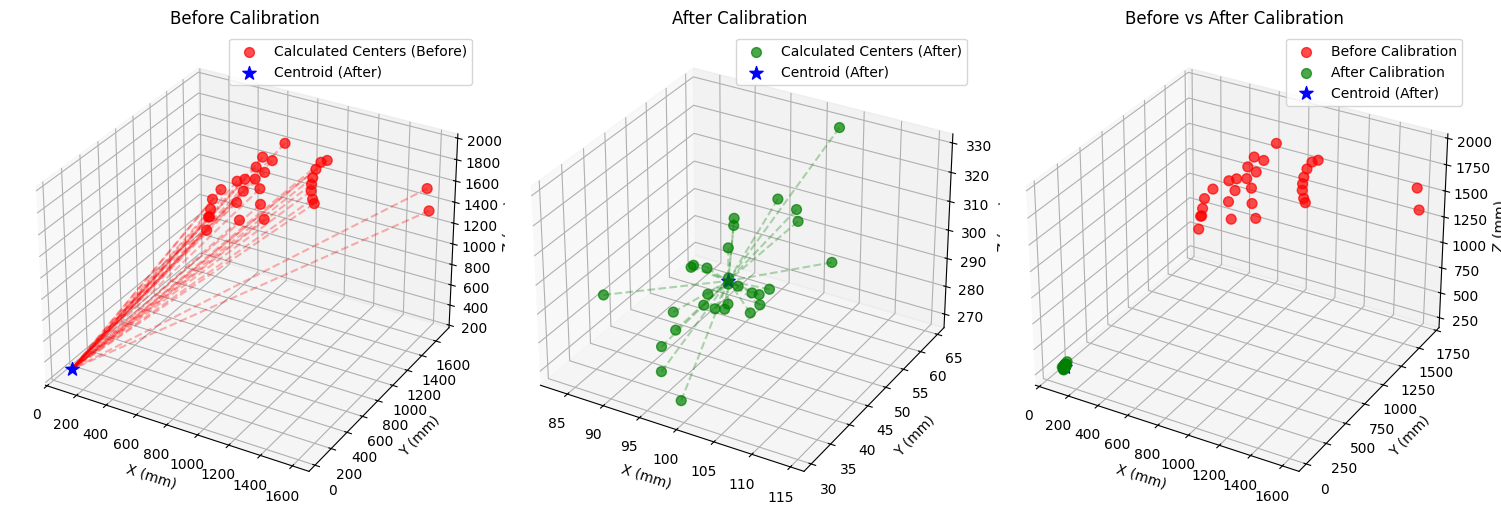


=== High-Precision Calibration Statistics ===
Reference point: Centroid of calibrated data
Reference center: [97.711, 45.406, 293.427] mm
Before calibration:
  Mean distance from reference: 1864.487 mm
  Std distance from reference: 289.444 mm
  Max distance from reference: 2533.356 mm
  Min distance from reference: 1342.017 mm

After calibration:
  Mean distance from reference: 13.88490770 mm
  Std distance from reference: 9.69694611 mm
  Max distance from reference: 40.47825069 mm
  Min distance from reference: 1.23325330 mm

Dispersion improvement: 96.65%
Mean distance improvement: 99.26%
Target precision (0.00010000mm): Not achieved
Points within target precision: 0/30 (0.0%)


In [8]:
from main_cali.data_anl import plot_calibration_results, plot_optimization_history

# ÁªòÂà∂Ê†°ÂáÜÂâçÂêéÁöÑÁªìÊûú
print("\nGenerating visualization...")
# Áé∞Âú®‰∏çÈúÄË¶ÅÊèê‰æõÁúüÂÆûÁêÉÂøÉÔºåÂáΩÊï∞‰ºöËá™Âä®‰ΩøÁî®Ê†°ÂáÜÂêéÊï∞ÊçÆÁöÑË¥®ÂøÉ‰Ωú‰∏∫ÂèÇËÄÉ
plot_calibration_results(results)

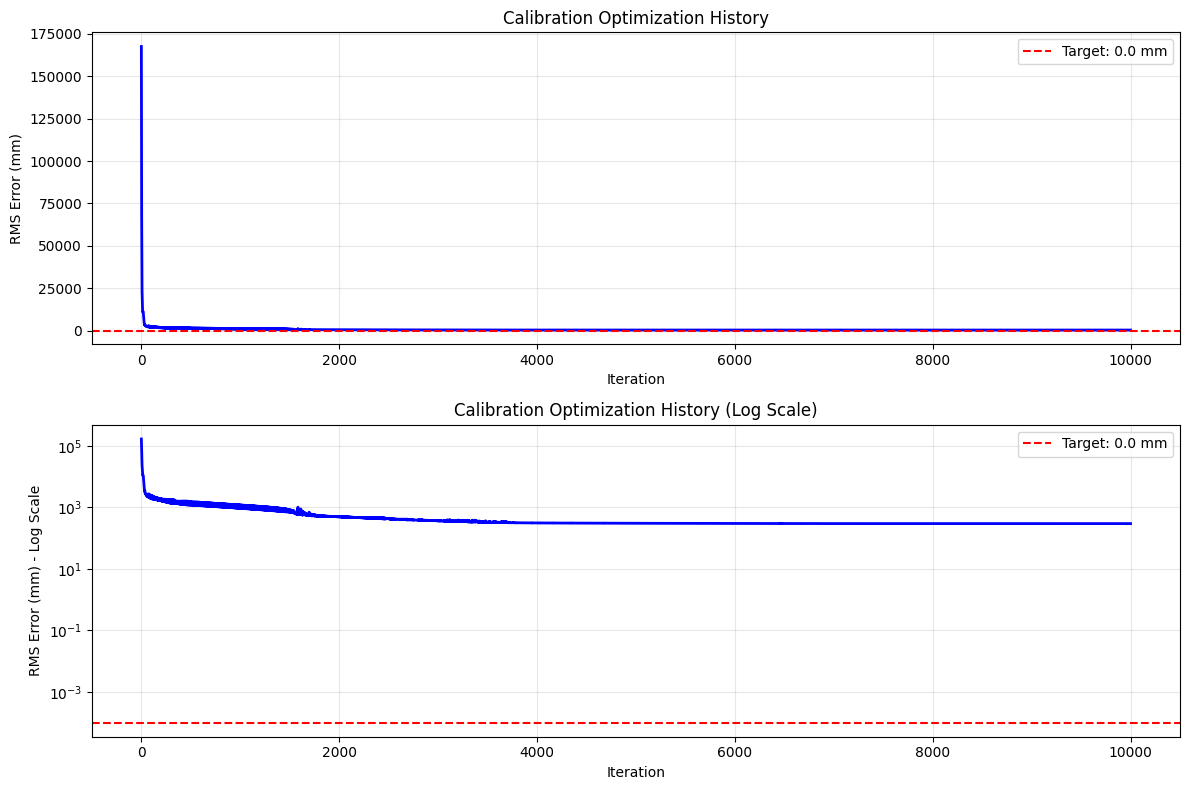

In [9]:
# ÁªòÂà∂‰ºòÂåñÂéÜÂè≤
plot_optimization_history(results)

## 8. ÁªìÊûúÂàÜÊûê

In [10]:
# ÂØπÊØîÊ†°ÂáÜÂâçÂêéÁöÑÊú∫Âô®‰∫∫ÂèÇÊï∞
print("\n=== Robot Parameters Comparison (Before vs After Calibration) ===")

if 'results' in locals() and results is not None:
    # ‰ªéÊ†°ÂáÜÁªìÊûú‰∏≠Ëé∑ÂèñÂèÇÊï∞ÂèòÂåñ‰ø°ÊÅØÔºà‰ΩøÁî®Ê≠£Á°ÆÁöÑÈîÆÂêçÔºâ
    initial_params = results.get('initial_params', {})
    final_params = results.get('final_params', {})
    
    if initial_params and final_params:
        print("\nüìä DH Parameters Changes:")
        print("=" * 80)
        
        # ÈÅçÂéÜÊØè‰∏™ÂÖ≥ËäÇÁöÑDHÂèÇÊï∞
        for joint_idx in range(robot.n):
            print(f"\nüîß Joint {joint_idx + 1} (Link {joint_idx + 1}):")
            print("-" * 40)
            
            # Ê£ÄÊü•ÊØè‰∏™DHÂèÇÊï∞ÁöÑÂèòÂåñ
            dh_params = ['a', 'alpha', 'd', 'beta', 'offset']
            
            for param in dh_params:
                # Ê†°ÂáÜÂô®‰ΩøÁî®ÁöÑÊ†ºÂºèÊòØ 'link_{idx}' -> {param: value}
                link_key = f'link_{joint_idx}'
                
                if (link_key in initial_params and link_key in final_params and
                    param in initial_params[link_key] and param in final_params[link_key]):
                    
                    initial_val = initial_params[link_key][param]
                    final_val = final_params[link_key][param]
                    change = final_val - initial_val
                    
                    # Ê†πÊçÆÂèÇÊï∞Á±ªÂûãÈÄâÊã©ÂêàÈÄÇÁöÑÂçï‰ΩçÂíåÁ≤æÂ∫¶
                    if param in ['a', 'd']:
                        unit = "mm"
                        precision = 3
                    else:  # alpha, beta, offset (ËßíÂ∫¶ÂèÇÊï∞)
                        unit = "rad"
                        precision = 6
                    
                    print(f"  {param}: {initial_val:.{precision}f} -> {final_val:.{precision}f} (change: {change:+.{precision}f} {unit})")
                else:
                    print(f"  {param}: Parameter not calibrated")
        
        print("\n" + "=" * 80)
        print("\nü§ñ Hand-Eye Parameters Changes:")
        print("-" * 40)
        
        # ÊâãÁúºÂèÇÊï∞ÂØπÊØî
        hand_eye_params = [
            ('tx', 'mm', 3), ('ty', 'mm', 3), ('tz', 'mm', 3),
            ('rx', 'rad', 6), ('ry', 'rad', 6), ('rz', 'rad', 6)
        ]
        
        for param, unit, precision in hand_eye_params:
            # Ê†°ÂáÜÂô®‰ΩøÁî®ÁöÑÊ†ºÂºèÊòØ 'hand_eye' -> {param: value}
            if ('hand_eye' in initial_params and 'hand_eye' in final_params and
                param in initial_params['hand_eye'] and param in final_params['hand_eye']):
                
                initial_val = initial_params['hand_eye'][param]
                final_val = final_params['hand_eye'][param]
                change = final_val - initial_val
                
                print(f"  {param}: {initial_val:.{precision}f} -> {final_val:.{precision}f} (change: {change:+.{precision}f} {unit})")
            else:
                print(f"  {param}: Parameter not calibrated or not available")
        
        # ËÆ°ÁÆóÂèÇÊï∞ÂèòÂåñÁöÑÁªüËÆ°‰ø°ÊÅØ
        print("\n" + "=" * 80)
        print("\nüìà Parameter Change Statistics:")
        print("-" * 40)
        
        all_changes = []
        significant_changes = []
        
        # Êî∂ÈõÜÊâÄÊúâDHÂèÇÊï∞ÂèòÂåñ
        for joint_idx in range(robot.n):
            link_key = f'link_{joint_idx}'
            if link_key in initial_params and link_key in final_params:
                for param in ['a', 'alpha', 'd', 'beta', 'offset']:
                    if param in initial_params[link_key] and param in final_params[link_key]:
                        change = abs(final_params[link_key][param] - initial_params[link_key][param])
                        all_changes.append(change)
                        
                        # ÂÆö‰πâÊòæËëóÂèòÂåñÁöÑÈòàÂÄº
                        if param in ['a', 'd']:
                            threshold = 0.1  # mm
                        else:  # alpha, beta, offset
                            threshold = 0.001  # rad
                        
                        if change > threshold:
                            significant_changes.append((f'link_{joint_idx}_{param}', change))
        
        # Êî∂ÈõÜÊâãÁúºÂèÇÊï∞ÂèòÂåñ
        if 'hand_eye' in initial_params and 'hand_eye' in final_params:
            for param in ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']:
                if param in initial_params['hand_eye'] and param in final_params['hand_eye']:
                    change = abs(final_params['hand_eye'][param] - initial_params['hand_eye'][param])
                    all_changes.append(change)
                    
                    # ÂÆö‰πâÊòæËëóÂèòÂåñÁöÑÈòàÂÄº
                    if param in ['tx', 'ty', 'tz']:
                        threshold = 0.1  # mm
                    else:  # rx, ry, rz
                        threshold = 0.001  # rad
                    
                    if change > threshold:
                        significant_changes.append((f'hand_eye_{param}', change))
        
        if all_changes:
            import numpy as np
            print(f"  Total parameters calibrated: {len(all_changes)}")
            print(f"  Mean absolute change: {np.mean(all_changes):.6f}")
            print(f"  Max absolute change: {np.max(all_changes):.6f}")
            print(f"  Min absolute change: {np.min(all_changes):.6f}")
            print(f"  Std of changes: {np.std(all_changes):.6f}")
        
        if significant_changes:
            print(f"\n  Significant changes (> threshold):")
            for param_key, change in sorted(significant_changes, key=lambda x: x[1], reverse=True):
                print(f"    {param_key}: {change:.6f}")
        else:
            print(f"\n  ‚úÖ No significant parameter changes detected")
        
        # ÊòæÁ§∫ÂΩìÂâçÊú∫Âô®‰∫∫ÁöÑÊúÄÁªàÂèÇÊï∞Áä∂ÊÄÅ
        print("\n" + "=" * 80)
        print("\nüéØ Final Calibrated Robot Parameters:")
        print("-" * 40)
        
        print("\nDH Parameters:")
        for i, link in enumerate(robot.links):
            print(f"  Link {i+1}: a={link.a.item():.3f}mm, d={link.d.item():.3f}mm, "
                  f"alpha={link.alpha.item():.6f}rad, beta={link.beta.item():.6f}rad, "
                  f"offset={link.offset.item():.6f}rad")
        
        print("\nHand-Eye Parameters:")
        print(f"  Translation: tx={robot.tx.item():.3f}mm, ty={robot.ty.item():.3f}mm, tz={robot.tz.item():.3f}mm")
        print(f"  Rotation: rx={robot.rx.item():.6f}rad, ry={robot.ry.item():.6f}rad, rz={robot.rz.item():.6f}rad")
        
    else:
        print("‚ùå Parameter comparison data not available in calibration results")
        print("Checking available keys in results:")
        print(f"Available keys: {list(results.keys())}")
        
        if 'initial_params' in results:
            print(f"Initial params structure: {results['initial_params']}")
        if 'final_params' in results:
            print(f"Final params structure: {results['final_params']}")

else:
    print("‚ùå No calibration results available for parameter comparison")
    print("Please run the calibration first (cell 12)")

print("\n" + "=" * 80)


=== Robot Parameters Comparison (Before vs After Calibration) ===

üìä DH Parameters Changes:

üîß Joint 1 (Link 1):
----------------------------------------
  a: 320.000 -> 123.926 (change: -196.074 mm)
  alpha: -1.570796 -> -3.160161 (change: -1.589364 rad)
  d: 780.000 -> 780.000 (change: +0.000 mm)
  beta: 0.000000 -> 0.000000 (change: +0.000000 rad)
  offset: 0.000000 -> 0.000000 (change: +0.000000 rad)

üîß Joint 2 (Link 2):
----------------------------------------
  a: 1125.000 -> 1149.931 (change: +24.931 mm)
  alpha: 0.000000 -> -0.175800 (change: -0.175800 rad)
  d: 0.000 -> 0.000 (change: +0.000 mm)
  beta: 0.000000 -> -1.165511 (change: -1.165511 rad)
  offset: -1.570796 -> -2.803780 (change: -1.232984 rad)

üîß Joint 3 (Link 3):
----------------------------------------
  a: 200.000 -> 141.884 (change: -58.116 mm)
  alpha: -1.570796 -> -0.045216 (change: +1.525580 rad)
  d: -0.000 -> -0.000 (change: +0.000 mm)
  beta: 0.000000 -> 0.000000 (change: +0.000000 rad)
  offs

In [11]:
# ÂàÜÊûêÊ†°ÂáÜÁªìÊûú
print("\n=== Calibration Analysis ===")
print(f"Initial Variance Error: {results['initial_variance_error']:.6f}")
print(f"Final Variance Error: {results['final_variance_error']:.6f}")
print(f"Target Precision (variance): {results['target_precision']:.2e}")
print(f"Precision Achieved: {results['precision_achieved']}")

if results['precision_achieved']:
    print("\n‚úÖ Successfully achieved variance precision target!")
else:
    print("\n‚ùå Failed to achieve variance precision target")
    print("Consider:")
    print("- Increasing number of samples")
    print("- Reducing measurement noise")
    print("- Adjusting optimization parameters")

# ËÆ°ÁÆó‰ΩçÁΩÆÊ†áÂáÜÂ∑Æ(ÊñπÂ∑ÆÁöÑÂπ≥ÊñπÊ†π)
import math
initial_std = math.sqrt(results['initial_variance_error'] / 3)  # Èô§‰ª•3ÊòØÂõ†‰∏∫x,y,z‰∏â‰∏™Áª¥Â∫¶
final_std = math.sqrt(results['final_variance_error'] / 3)

print(f"\n=== Position Standard Deviation Analysis ===")
print(f"Initial Position Std Dev: {initial_std:.3f} mm")
print(f"Final Position Std Dev: {final_std:.3f} mm")

if final_std < 1.0:
    print("‚úÖ Position precision is better than 1mm (1œÉ)")
else:
    print("‚ùå Position precision is worse than 1mm (1œÉ)")


=== Calibration Analysis ===
Initial Variance Error: 167610.224966
Final Variance Error: 296.711820
Target Precision (variance): 1.00e-04
Precision Achieved: False

‚ùå Failed to achieve variance precision target
Consider:
- Increasing number of samples
- Reducing measurement noise
- Adjusting optimization parameters

=== Position Standard Deviation Analysis ===
Initial Position Std Dev: 236.369 mm
Final Position Std Dev: 9.945 mm
‚ùå Position precision is worse than 1mm (1œÉ)


## 9. Ê†áÂÆöÈ™åËØÅÔºötest_dataÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑ÆÂàÜÊûê

In [12]:
from robot_model.robots import create_robot
from main_cali.calibrator import RobotCalibrator
import numpy as np
import torch
import copy

print("=== Ê†áÂÆöÈ™åËØÅÔºö‰ΩøÁî®test_dataËøõË°åÈ™åËØÅ ===")

# ÈÖçÁΩÆtest_dataÊï∞ÊçÆË∑ØÂæÑ - ‰ΩøÁî®Êñ∞Ê†ºÂºèÁöÑobservations.jsonÊñá‰ª∂
test_data_file = os.path.join(os.getcwd(), "data", "test_data", "pose1", "observations.json")

print(f"Ê≠£Âú®Âä†ËΩΩtest_dataËßÇÊµãÊï∞ÊçÆ...")
print(f"Êï∞ÊçÆÊñá‰ª∂Ë∑ØÂæÑ: {test_data_file}")


=== Ê†áÂÆöÈ™åËØÅÔºö‰ΩøÁî®test_dataËøõË°åÈ™åËØÅ ===
Ê≠£Âú®Âä†ËΩΩtest_dataËßÇÊµãÊï∞ÊçÆ...
Êï∞ÊçÆÊñá‰ª∂Ë∑ØÂæÑ: d:\Ê°åÈù¢\ÂÆû‰π†\diff_cali\data\test_data\pose1\observations.json


In [13]:
# Ê£ÄÊü•test_dataÊñá‰ª∂ÊòØÂê¶Â≠òÂú®
if not os.path.exists(test_data_file):
    print(f"‚ùå ÊµãËØïÊï∞ÊçÆÊñá‰ª∂ {test_data_file} ‰∏çÂ≠òÂú®")
    print("ËØ∑ÂÖàËøêË°åÊï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÁ®ãÂ∫èÁîüÊàêobservations.jsonÊñá‰ª∂")
else:
    try:
        # ÂàõÂª∫‰∏¥Êó∂Ê†°ÂáÜÂô®Áî®‰∫éÂä†ËΩΩÊµãËØïÊï∞ÊçÆ
        temp_calibrator = RobotCalibrator(robot)
        
        # ‰ªéJSONÊñá‰ª∂Âä†ËΩΩÊµãËØïÊï∞ÊçÆ
        print("Ê≠£Âú®‰ªéJSONÊñá‰ª∂Âä†ËΩΩÊµãËØïËßÇÊµãÊï∞ÊçÆ...")
        success = temp_calibrator.load_observations_from_json(test_data_file,30)
        
        if success:
            test_observations = temp_calibrator.observations
            print(f"‚úì ÊàêÂäüÂä†ËΩΩ {len(test_observations)} ‰∏™ÊµãËØïËßÇÊµãÊï∞ÊçÆ")
            
            # Ê£ÄÊü•Êï∞ÊçÆÊ†ºÂºè
            if len(test_observations) > 0:
                sample_obs = test_observations[0]
                has_point_cloud_center = 'point_cloud_center' in sample_obs and sample_obs['point_cloud_center'] is not None
                
                if has_point_cloud_center:
                    print("‚úì ÊµãËØïÊï∞ÊçÆÂåÖÂê´ÁÇπ‰∫ë‰∏≠ÂøÉ‰ø°ÊÅØÔºåÂèØ‰ª•ËøõË°åÈ™åËØÅ")
                    
                    # ‰ªécalibration resultsËé∑ÂèñÊ†áÂÆöÂâçÂêéÁöÑÂèÇÊï∞
                    if 'results' in locals() and results is not None:
                        initial_params = results.get('initial_params', {})
                        final_params = results.get('final_params', {})
                        
                        if initial_params and final_params:
                            print("\n=== ÂàõÂª∫Ê†áÂÆöÂâçÂêéÁöÑÊú∫Âô®‰∫∫Ê®°Âûã ===")
                            
                            # ÂàõÂª∫Ê†áÂÆöÂâçÁöÑÊú∫Âô®‰∫∫Ê®°ÂûãÔºà‰ΩøÁî®ÂàùÂßãÂèÇÊï∞Ôºâ
                            robot_before = create_robot(robot_name=robot_name)
                            
                            # Â∫îÁî®ÂàùÂßãÂèÇÊï∞
                            for joint_idx in range(robot_before.n):
                                link_key = f'link_{joint_idx}'
                                if link_key in initial_params:
                                    link_params = initial_params[link_key]
                                    for param_name, param_value in link_params.items():
                                        if hasattr(robot_before.links[joint_idx], param_name):
                                            # ‰ΩøÁî®.dataÂ±ûÊÄßÊù•Êõ¥Êñ∞torch.nn.ParameterÁöÑÂÄº
                                            current_attr = getattr(robot_before.links[joint_idx], param_name)
                                            if isinstance(current_attr, torch.nn.Parameter):
                                                current_attr.data = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                            elif isinstance(current_attr, torch.Tensor):
                                                new_tensor = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                                setattr(robot_before.links[joint_idx], param_name, new_tensor)
                            
                            # Â∫îÁî®ÂàùÂßãÊâãÁúºÂèÇÊï∞
                            if 'hand_eye' in initial_params:
                                he_params = initial_params['hand_eye']
                                for param_name, param_value in he_params.items():
                                    if hasattr(robot_before, param_name):
                                        # ‰ΩøÁî®.dataÂ±ûÊÄßÊù•Êõ¥Êñ∞torch.nn.ParameterÁöÑÂÄº
                                        current_attr = getattr(robot_before, param_name)
                                        if isinstance(current_attr, torch.nn.Parameter):
                                            current_attr.data = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                        elif isinstance(current_attr, torch.Tensor):
                                            new_tensor = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                            setattr(robot_before, param_name, new_tensor)
                            
                            print("‚úì Ê†áÂÆöÂâçÊú∫Âô®‰∫∫Ê®°ÂûãÂ∑≤ÂàõÂª∫")
                            
                            # Ê†áÂÆöÂêéÁöÑÊú∫Âô®‰∫∫Ê®°ÂûãÂ∞±ÊòØÂΩìÂâçÁöÑrobot
                            robot_after = robot
                            print("‚úì Ê†áÂÆöÂêéÊú∫Âô®‰∫∫Ê®°ÂûãÂ∑≤ÂáÜÂ§áÂ∞±Áª™")
                            
                            # ‰ΩøÁî®Ê†áÂÆöÂô®ÁöÑÊñπÂ∑ÆËÆ°ÁÆóÊñπÊ≥ï
                            def calculate_point_cloud_variance_with_calibrator(robot_model, observations):
                                """‰ΩøÁî®Ê†áÂÆöÂô®ÁöÑÊñπÂ∑ÆËÆ°ÁÆóÊñπÊ≥ïËÆ°ÁÆóÁÇπ‰∫ë‰∏≠ÂøÉËΩ¨Êç¢Âà∞Âü∫ÂùêÊ†áÁ≥ªÂêéÁöÑÊñπÂ∑Æ"""
                                # ÂàõÂª∫‰∏¥Êó∂Ê†áÂÆöÂô®Ôºå‰ΩøÁî®Áõ∏ÂêåÁöÑÂèÇÊï∞ÂíåÊéíÈô§ËßÑÂàô
                                temp_calibrator = RobotCalibrator(robot_model)
                                
                                # ËÆæÁΩÆËßÇÊµãÊï∞ÊçÆ
                                temp_calibrator.set_observations(observations)
                                
                                # Ë∞ÉÁî®Ê†áÂÆöÂô®ÁöÑÊñπÂ∑ÆËÆ°ÁÆóÊñπÊ≥ï
                                variance_error = temp_calibrator._compute_variance_error()
                                
                                # Ëé∑ÂèñËΩ¨Êç¢ÂêéÁöÑÁÇπ‰∫ë‰∏≠ÂøÉ‰ΩçÁΩÆÁî®‰∫éÂèØËßÜÂåñ
                                transformed_centers = []
                                for obs in observations:
                                    joint_angles = obs['joint_state']
                                    point_cloud_center = obs['point_cloud_center']
                                    
                                    if point_cloud_center is not None:
                                        # ÁÇπ‰∫ë‰∏≠ÂøÉÂ∑≤ÁªèÈ¢ÑËÆ°ÁÆóÂ•Ω‰∫Ü
                                        if isinstance(point_cloud_center, np.ndarray):
                                            pc_center = point_cloud_center
                                        else:
                                            pc_center = np.array(point_cloud_center)
                                        
                                        # Â∞ÜÁÇπ‰∫ë‰∏≠ÂøÉËΩ¨Êç¢‰∏∫ÈΩêÊ¨°ÂùêÊ†á
                                        pc_center_homo = np.append(pc_center, 1.0)
                                        
                                        # Á°Æ‰øùÂÖ≥ËäÇËßíÂ∫¶ÊòØÊ≠£Á°ÆÁöÑÊï∞ÊçÆÁ±ªÂûã
                                        if isinstance(joint_angles, np.ndarray):
                                            joint_angles = joint_angles.astype(np.float64)
                                        elif isinstance(joint_angles, list):
                                            joint_angles = np.array(joint_angles, dtype=np.float64)
                                        
                                        # ÈÄöËøáÊú∫Âô®‰∫∫Ê≠£ËøêÂä®Â≠¶Ëé∑ÂæóÊú´Á´ØÂà∞Âü∫ÂùêÊ†áÁ≥ªÁöÑÂèòÊç¢Áü©Èòµ
                                        T_base_to_end = robot_model.fkine(joint_angles)
                                        
                                        # Â∞ÜÁõ∏Êú∫ÂùêÊ†áÁ≥ªÁöÑÁÇπËΩ¨Êç¢Âà∞Âü∫ÂùêÊ†áÁ≥ª
                                        # Á°Æ‰øùÊï∞ÊçÆÁ±ªÂûãÂåπÈÖç
                                        pc_center_tensor = torch.tensor(pc_center_homo, dtype=T_base_to_end.dtype, device=T_base_to_end.device)
                                        pc_center_base = T_base_to_end @ pc_center_tensor
                                        
                                        # Âè™‰øùÁïôxyzÂùêÊ†á
                                        transformed_centers.append(pc_center_base[:3].detach().numpy())
                                
                                if len(transformed_centers) == 0:
                                    return 0.0, np.array([])
                                
                                transformed_centers = np.array(transformed_centers)
                                
                                return variance_error, transformed_centers
                            
                            print("\n=== ‰ΩøÁî®Ê†áÂÆöÂô®ÊñπÊ≥ïËÆ°ÁÆóÊ†áÂÆöÂâçÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ ===")
                            
                            # ËÆ°ÁÆóÊ†áÂÆöÂâçÁöÑÊñπÂ∑Æ
                            print("Ê≠£Âú®‰ΩøÁî®Ê†áÂÆöÂô®ÊñπÊ≥ïËÆ°ÁÆóÊ†áÂÆöÂâçÁöÑÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ...")
                            variance_before, centers_before = calculate_point_cloud_variance_with_calibrator(robot_before, test_observations)
                            
                            # ËÆ°ÁÆóÊ†áÂÆöÂêéÁöÑÊñπÂ∑Æ
                            print("Ê≠£Âú®‰ΩøÁî®Ê†áÂÆöÂô®ÊñπÊ≥ïËÆ°ÁÆóÊ†áÂÆöÂêéÁöÑÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ...")
                            variance_after, centers_after = calculate_point_cloud_variance_with_calibrator(robot_after, test_observations)
                            
                            print(f"\n=== È™åËØÅÁªìÊûú ===")
                            print(f"ÊµãËØïÊï∞ÊçÆÁÇπÊï∞: {len(test_observations)}")
                            print(f"Ê†áÂÆöÂâçÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ: {variance_before.item():.6f} mm¬≤")
                            print(f"Ê†áÂÆöÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ: {variance_after.item():.6f} mm¬≤")
                            print(f"ÊñπÂ∑ÆÊîπÂñÑ: {(variance_before.item() - variance_after.item()):.6f} mm¬≤ ({((variance_before.item() - variance_after.item())/variance_before.item()*100):.2f}%)")
                            
                            # ËÆ°ÁÆóÊ†áÂáÜÂ∑Æ
                            std_before = np.sqrt(variance_before.item())
                            std_after = np.sqrt(variance_after.item())
                            print(f"\nÊ†áÂÆöÂâçÁÇπ‰∫ë‰∏≠ÂøÉÊ†áÂáÜÂ∑Æ: {std_before:.3f} mm")
                            print(f"Ê†áÂÆöÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊ†áÂáÜÂ∑Æ: {std_after:.3f} mm")
                            print(f"Ê†áÂáÜÂ∑ÆÊîπÂñÑ: {std_before - std_after:.3f} mm ({((std_before - std_after)/std_before*100):.2f}%)")
                            
                            # Âà§Êñ≠ÊòØÂê¶ËææÂà∞ÁõÆÊ†áÁ≤æÂ∫¶
                            if std_after < 1.0:
                                print("\n‚úÖ È™åËØÅÊàêÂäüÔºöÊ†áÂÆöÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊ†áÂáÜÂ∑Æ < 1mm")
                            else:
                                print("\n‚ö†Ô∏è  È™åËØÅÁªìÊûúÔºöÊ†áÂÆöÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊ†áÂáÜÂ∑Æ‰ªç > 1mm")
                            
                            # ‰øùÂ≠òÈ™åËØÅÊï∞ÊçÆ‰æõÂêéÁª≠ÂèØËßÜÂåñ‰ΩøÁî®
                            validation_data = {
                                'centers_before': centers_before,
                                'centers_after': centers_after,
                                'variance_before': variance_before.item(),
                                'variance_after': variance_after.item(),
                                'std_before': std_before,
                                'std_after': std_after
                            }
                            
                            print("‚úì È™åËØÅÊï∞ÊçÆÂ∑≤‰øùÂ≠òÔºåÂèØÁî®‰∫éÂêéÁª≠ÂèØËßÜÂåñ")
                            
                        else:
                            print("‚ùå Êó†Ê≥ïËé∑ÂèñÊ†áÂÆöÂâçÂêéÁöÑÂèÇÊï∞Êï∞ÊçÆ")
                    else:
                        print("‚ùå Êú™ÊâæÂà∞Ê†áÂÆöÁªìÊûúÔºåËØ∑ÂÖàËøêË°åÊ†áÂÆö")
                else:
                    print("‚ùå ÊµãËØïÊï∞ÊçÆ‰∏çÂåÖÂê´ÁÇπ‰∫ë‰∏≠ÂøÉ‰ø°ÊÅØÔºåÊó†Ê≥ïËøõË°åÈ™åËØÅ")
            else:
                print("‚ùå ÊµãËØïÊï∞ÊçÆ‰∏∫Á©∫")
        else:
            print("‚ùå ÊµãËØïÊï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•")
    
    except Exception as e:
        print(f"‚ùå È™åËØÅËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {str(e)}")
        import traceback
        traceback.print_exc()

Ê≠£Âú®‰ªéJSONÊñá‰ª∂Âä†ËΩΩÊµãËØïËßÇÊµãÊï∞ÊçÆ...
Loaded 10 observations with precomputed centers
‚úì ÊàêÂäü‰ªé d:\Ê°åÈù¢\ÂÆû‰π†\diff_cali\data\test_data\pose1\observations.json Âä†ËΩΩ 10 ‰∏™ËßÇÊµãÊï∞ÊçÆ
‚úì ÊàêÂäüÂä†ËΩΩ 10 ‰∏™ÊµãËØïËßÇÊµãÊï∞ÊçÆ
‚úì ÊµãËØïÊï∞ÊçÆÂåÖÂê´ÁÇπ‰∫ë‰∏≠ÂøÉ‰ø°ÊÅØÔºåÂèØ‰ª•ËøõË°åÈ™åËØÅ

=== ÂàõÂª∫Ê†áÂÆöÂâçÂêéÁöÑÊú∫Âô®‰∫∫Ê®°Âûã ===
‚úì Ê†áÂÆöÂâçÊú∫Âô®‰∫∫Ê®°ÂûãÂ∑≤ÂàõÂª∫
‚úì Ê†áÂÆöÂêéÊú∫Âô®‰∫∫Ê®°ÂûãÂ∑≤ÂáÜÂ§áÂ∞±Áª™

=== ‰ΩøÁî®Ê†áÂÆöÂô®ÊñπÊ≥ïËÆ°ÁÆóÊ†áÂÆöÂâçÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ ===
Ê≠£Âú®‰ΩøÁî®Ê†áÂÆöÂô®ÊñπÊ≥ïËÆ°ÁÆóÊ†áÂÆöÂâçÁöÑÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ...
Loaded 10 observations with precomputed centers
Ê≠£Âú®‰ΩøÁî®Ê†áÂÆöÂô®ÊñπÊ≥ïËÆ°ÁÆóÊ†áÂÆöÂêéÁöÑÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ...
Loaded 10 observations with precomputed centers

=== È™åËØÅÁªìÊûú ===
ÊµãËØïÊï∞ÊçÆÁÇπÊï∞: 10
Ê†áÂÆöÂâçÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ: 918472.467962 mm¬≤
Ê†áÂÆöÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊñπÂ∑Æ: 8114.698917 mm¬≤
ÊñπÂ∑ÆÊîπÂñÑ: 910357.769045 mm¬≤ (99.12%)

Ê†áÂÆöÂâçÁÇπ‰∫ë‰∏≠ÂøÉÊ†áÂáÜÂ∑Æ: 958.370 mm
Ê†áÂÆöÂêéÁÇπ‰∫ë‰∏≠ÂøÉÊ†áÂáÜÂ∑Æ: 90.082 mm
Ê†á


=== ÂèØËßÜÂåñÈ™åËØÅÁªìÊûú ===


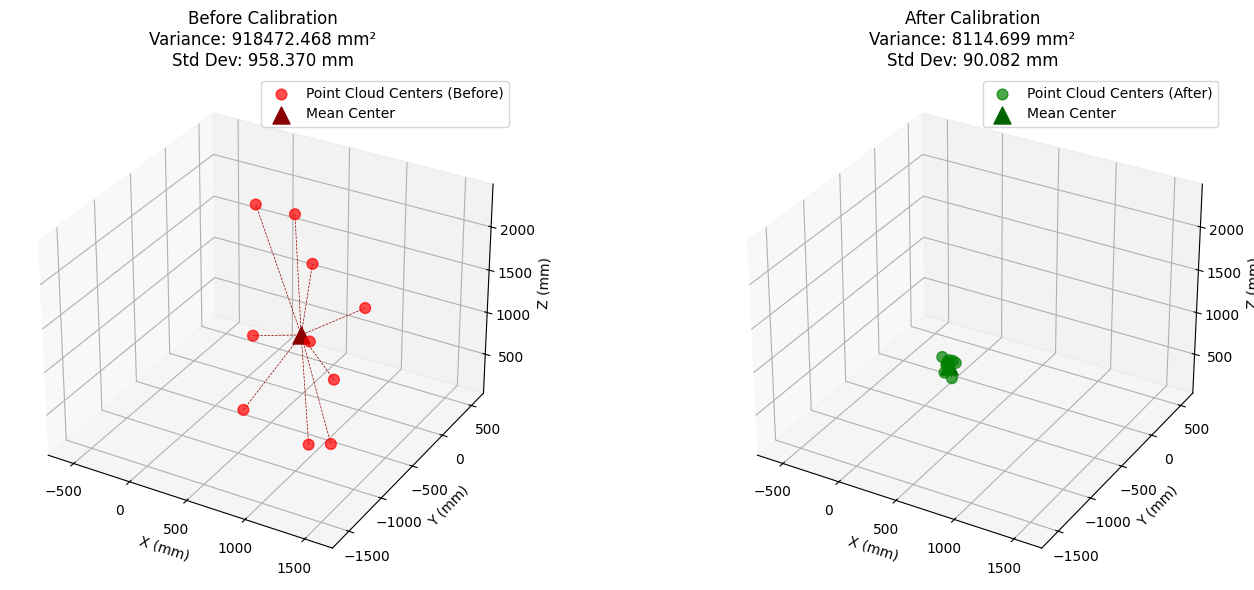

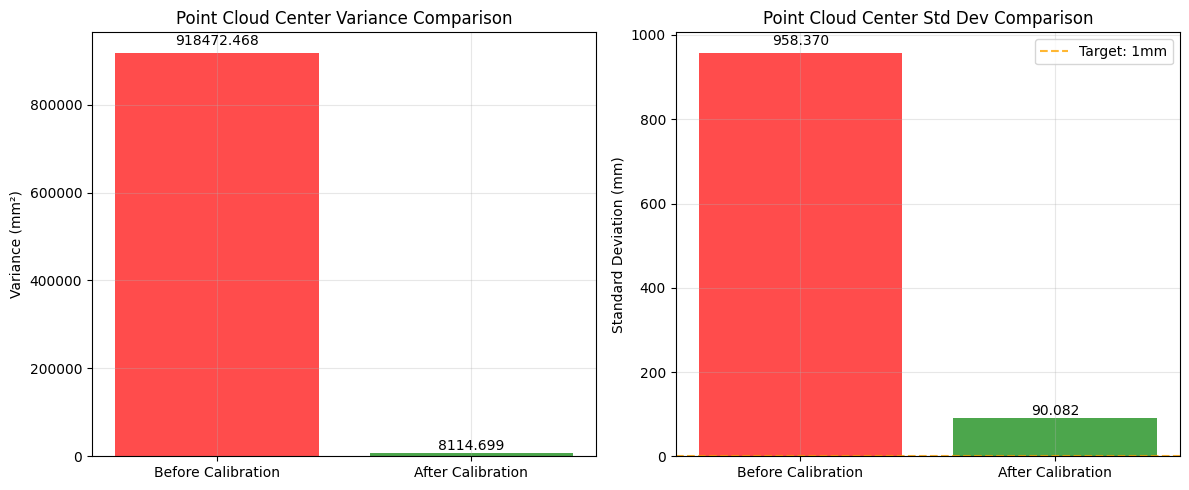


=== ËØ¶ÁªÜÁªüËÆ°ÂØπÊØî ===
ÊµãËØïÊ†∑Êú¨Êï∞Èáè: 10

Ê†áÂÆöÂâçÁªüËÆ°:
  ‰∏≠ÂøÉ‰ΩçÁΩÆ: [815.45, -593.93, 1259.04] mm
  XËΩ¥ËåÉÂõ¥: 349.90 ~ 1106.41 mm (span: 756.51 mm)
  YËΩ¥ËåÉÂõ¥: -1222.59 ~ 190.90 mm (span: 1413.48 mm)
  ZËΩ¥ËåÉÂõ¥: 26.29 ~ 2486.86 mm (span: 2460.57 mm)

Ê†áÂÆöÂêéÁªüËÆ°:
  ‰∏≠ÂøÉ‰ΩçÁΩÆ: [-26.40, -86.30, 215.82] mm
  XËΩ¥ËåÉÂõ¥: -107.37 ~ 52.69 mm (span: 160.05 mm)
  YËΩ¥ËåÉÂõ¥: -170.72 ~ -48.61 mm (span: 122.10 mm)
  ZËΩ¥ËåÉÂõ¥: 126.00 ~ 311.13 mm (span: 185.13 mm)

=== ÊîπÂñÑÊÉÖÂÜµ ===
ÊñπÂ∑ÆÊîπÂñÑ: 99.12%
Ê†áÂáÜÂ∑ÆÊîπÂñÑ: 90.60%
‚ùå Êú™ËææÊ†áÔºöÊ†áÂÆöÂêéÊ†áÂáÜÂ∑Æ 90.082mm > 1mm ÁõÆÊ†á


In [14]:
# ÂèØËßÜÂåñÈ™åËØÅÁªìÊûú
if 'validation_data' in locals():
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    print("\n=== ÂèØËßÜÂåñÈ™åËØÅÁªìÊûú ===")
    
    centers_before = validation_data['centers_before']
    centers_after = validation_data['centers_after']
    
    if len(centers_before) > 0 and len(centers_after) > 0:
        # ÂàõÂª∫3DÂØπÊØîÂõæ
        fig = plt.figure(figsize=(15, 6))
        
        # Ê†áÂÆöÂâçÁöÑÂàÜÂ∏É
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(centers_before[:, 0], centers_before[:, 1], centers_before[:, 2], 
                   c='red', alpha=0.7, s=60, label='Point Cloud Centers (Before)')
        
        
        # ËÆ°ÁÆóÂπ∂ÊòæÁ§∫‰∏≠ÂøÉÁÇπ
        center_before = np.mean(centers_before, axis=0)
        ax1.scatter(center_before[0], center_before[1], center_before[2], 
                   c='darkred', s=150, marker='^', label='Mean Center')
        
        # ‰ªéÊØè‰∏™ÁÇπÂà∞‰∏≠ÂøÉÁöÑËøûÁ∫ø
        for i, pos in enumerate(centers_before):
            ax1.plot([pos[0], center_before[0]], [pos[1], center_before[1]], [pos[2], center_before[2]], 
                    'darkred', alpha=1, linewidth=0.5, linestyle='--')
        
        ax1.set_xlabel('X (mm)')
        ax1.set_ylabel('Y (mm)')
        ax1.set_zlabel('Z (mm)')
        ax1.set_title(f'Before Calibration\nVariance: {validation_data["variance_before"]:.3f} mm¬≤\nStd Dev: {validation_data["std_before"]:.3f} mm')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Ê†áÂÆöÂêéÁöÑÂàÜÂ∏É
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(centers_after[:, 0], centers_after[:, 1], centers_after[:, 2], 
                   c='green', alpha=0.7, s=60, label='Point Cloud Centers (After)')
        
        
        # ËÆ°ÁÆóÂπ∂ÊòæÁ§∫‰∏≠ÂøÉÁÇπ
        center_after = np.mean(centers_after, axis=0)
        ax2.scatter(center_after[0], center_after[1], center_after[2], 
                   c='darkgreen', s=150, marker='^', label='Mean Center')
        
        # ‰ªéÊØè‰∏™ÁÇπÂà∞‰∏≠ÂøÉÁöÑËøûÁ∫ø
        for i, pos in enumerate(centers_after):
            ax2.plot([pos[0], center_after[0]], [pos[1], center_after[1]], [pos[2], center_after[2]], 
                    'darkgreen', alpha=1, linewidth=0.5, linestyle='--')
        
        ax2.set_xlabel('X (mm)')
        ax2.set_ylabel('Y (mm)')
        ax2.set_zlabel('Z (mm)')
        ax2.set_title(f'After Calibration\nVariance: {validation_data["variance_after"]:.3f} mm¬≤\nStd Dev: {validation_data["std_after"]:.3f} mm')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # ËÆæÁΩÆÁõ∏ÂêåÁöÑÂùêÊ†áËΩ¥ËåÉÂõ¥‰ª•‰æøÂØπÊØî
        all_centers = np.vstack([centers_before, centers_after])
        for ax in [ax1, ax2]:
            max_range = np.array([all_centers[:,0].max()-all_centers[:,0].min(),
                                  all_centers[:,1].max()-all_centers[:,1].min(),
                                  all_centers[:,2].max()-all_centers[:,2].min()]).max() / 2.0
            mid_x = (all_centers[:,0].max()+all_centers[:,0].min()) * 0.5
            mid_y = (all_centers[:,1].max()+all_centers[:,1].min()) * 0.5
            mid_z = (all_centers[:,2].max()+all_centers[:,2].min()) * 0.5
            
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        plt.tight_layout()
        plt.show()
        
        # ÂàõÂª∫ÁªüËÆ°ÂØπÊØîÂõæ
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # ÊñπÂ∑ÆÂØπÊØî
        categories = ['Before Calibration', 'After Calibration']
        variances = [validation_data['variance_before'], validation_data['variance_after']]
        colors = ['red', 'green']
        
        bars1 = ax1.bar(categories, variances, color=colors, alpha=0.7)
        ax1.set_ylabel('Variance (mm¬≤)')
        ax1.set_title('Point Cloud Center Variance Comparison')
        ax1.grid(True, alpha=0.3)
        
        # Âú®Êü±Áä∂Âõæ‰∏äÊ∑ªÂä†Êï∞ÂÄºÊ†áÁ≠æ
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        # Ê†áÂáÜÂ∑ÆÂØπÊØî
        std_devs = [validation_data['std_before'], validation_data['std_after']]
        bars2 = ax2.bar(categories, std_devs, color=colors, alpha=0.7)
        ax2.set_ylabel('Standard Deviation (mm)')
        ax2.set_title('Point Cloud Center Std Dev Comparison')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=1.0, color='orange', linestyle='--', alpha=0.8, label='Target: 1mm')
        ax2.legend()
        
        # Âú®Êü±Áä∂Âõæ‰∏äÊ∑ªÂä†Êï∞ÂÄºÊ†áÁ≠æ
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # ÊâìÂç∞ËØ¶ÁªÜÁªüËÆ°‰ø°ÊÅØ
        print(f"\n=== ËØ¶ÁªÜÁªüËÆ°ÂØπÊØî ===")
        print(f"ÊµãËØïÊ†∑Êú¨Êï∞Èáè: {len(centers_before)}")
        print(f"\nÊ†áÂÆöÂâçÁªüËÆ°:")
        print(f"  ‰∏≠ÂøÉ‰ΩçÁΩÆ: [{center_before[0]:.2f}, {center_before[1]:.2f}, {center_before[2]:.2f}] mm")
        print(f"  XËΩ¥ËåÉÂõ¥: {centers_before[:,0].min():.2f} ~ {centers_before[:,0].max():.2f} mm (span: {centers_before[:,0].max()-centers_before[:,0].min():.2f} mm)")
        print(f"  YËΩ¥ËåÉÂõ¥: {centers_before[:,1].min():.2f} ~ {centers_before[:,1].max():.2f} mm (span: {centers_before[:,1].max()-centers_before[:,1].min():.2f} mm)")
        print(f"  ZËΩ¥ËåÉÂõ¥: {centers_before[:,2].min():.2f} ~ {centers_before[:,2].max():.2f} mm (span: {centers_before[:,2].max()-centers_before[:,2].min():.2f} mm)")
        
        print(f"\nÊ†áÂÆöÂêéÁªüËÆ°:")
        print(f"  ‰∏≠ÂøÉ‰ΩçÁΩÆ: [{center_after[0]:.2f}, {center_after[1]:.2f}, {center_after[2]:.2f}] mm")
        print(f"  XËΩ¥ËåÉÂõ¥: {centers_after[:,0].min():.2f} ~ {centers_after[:,0].max():.2f} mm (span: {centers_after[:,0].max()-centers_after[:,0].min():.2f} mm)")
        print(f"  YËΩ¥ËåÉÂõ¥: {centers_after[:,1].min():.2f} ~ {centers_after[:,1].max():.2f} mm (span: {centers_after[:,1].max()-centers_after[:,1].min():.2f} mm)")
        print(f"  ZËΩ¥ËåÉÂõ¥: {centers_after[:,2].min():.2f} ~ {centers_after[:,2].max():.2f} mm (span: {centers_after[:,2].max()-centers_after[:,2].min():.2f} mm)")
        
        # ËÆ°ÁÆóÊîπÂñÑÁôæÂàÜÊØî
        variance_improvement = (validation_data['variance_before'] - validation_data['variance_after']) / validation_data['variance_before'] * 100
        std_improvement = (validation_data['std_before'] - validation_data['std_after']) / validation_data['std_before'] * 100
        
        print(f"\n=== ÊîπÂñÑÊÉÖÂÜµ ===")
        print(f"ÊñπÂ∑ÆÊîπÂñÑ: {variance_improvement:.2f}%")
        print(f"Ê†áÂáÜÂ∑ÆÊîπÂñÑ: {std_improvement:.2f}%")
        
        if validation_data['std_after'] < 1.0:
            print(f"‚úÖ È™åËØÅÈÄöËøáÔºöÊ†áÂÆöÂêéÊ†áÂáÜÂ∑Æ {validation_data['std_after']:.3f}mm < 1mm ÁõÆÊ†á")
        else:
            print(f"‚ùå Êú™ËææÊ†áÔºöÊ†áÂÆöÂêéÊ†áÂáÜÂ∑Æ {validation_data['std_after']:.3f}mm > 1mm ÁõÆÊ†á")
            
    else:
        print("‚ùå Ê≤°ÊúâË∂≥Â§üÁöÑÊï∞ÊçÆËøõË°åÂèØËßÜÂåñ")
else:
    print("‚ùå Êú™ÊâæÂà∞È™åËØÅÊï∞ÊçÆÔºåËØ∑ÂÖàËøêË°å‰∏ä‰∏Ä‰∏™È™åËØÅÂçïÂÖÉ")